In [1]:
import pandas as pd


In [2]:
#motif="pos_patterns.pattern_8.ELK4_MA0076.2_pos_patterns.pattern_8.ELK4_MA0076.2"
#motif="pos_patterns.pattern_0.CTCF_MA0139.1_pos_patterns.pattern_0.CTCF_MA0139.1"
#motif="pos_patterns.pattern_1.HNF4G_MA0484.1_pos_patterns.pattern_1.HNF4G_MA0484.1"
#motif="pos_patterns.pattern_1.CTCF_MA0139.1_pos_patterns.pattern_1.CTCF_MA0139.1"
#motif="pos_patterns.pattern_5.NFKB1_HUMAN.H11MO.1.B_pos_patterns.pattern_5.NFKB1_HUMAN.H11MO.1.B"
#motif="pos_patterns.pattern_0.IRF1_MOUSE.H11MO.0.A_pos_patterns.pattern_0.IRF1_MOUSE.H11MO.0.A"
motif="pos_patterns.pattern_7.Gabpa_MA0062.2_pos_patterns.pattern_7.Gabpa_MA0062.2"
celltype="GM12878"
print(motif)
hits_path="/mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/"+celltype+"/"+celltype+"_ATAC_TOBIAS_NEW_COUNTS/"+motif+"/beds/"+motif+"_"+celltype+"_bound.bed"
chip_encid="ENCSR000DZN"
#hits_path="/mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/"+celltype+"/"+celltype+"_ATAC_TOBIAS_NEW_COUNTS/"+motif+"/beds/ENCSR000DZN_in_peaks_all.bed"

#hits_path="/mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/"+celltype+"/"+celltype+"_ATAC_TOBIAS_NEW_COUNTS/"+motif+"/beds/"+motif+"_all.bed"

hits = pd.read_csv(hits_path,sep="\t", header=None)



pos_patterns.pattern_7.Gabpa_MA0062.2_pos_patterns.pattern_7.Gabpa_MA0062.2


In [3]:
mode = 'counts'

celltype="GM12878"
modisco_path = '/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/'+celltype+'/merge_folds_new/counts/modisco_old_format.h5'
import h5py
import numpy as np
def fetch_modisco_motifs():
    dict_motifs={}
    modisco_results = h5py.File(modisco_path, 'r')

    for metacluster_name in modisco_results["metacluster_idx_to_submetacluster_results"]:
        #print(metacluster_name)

        metacluster = modisco_results["metacluster_idx_to_submetacluster_results"][metacluster_name]
        all_pattern_names = [x for x in list(metacluster["seqlets_to_patterns_result"]["patterns"]["all_pattern_names"][:])]

        for pattern_name in all_pattern_names:
            #print(pattern_name)

            ppm = np.array(metacluster['seqlets_to_patterns_result']['patterns'][pattern_name]['sequence']['fwd'])
            cwm = np.array(metacluster['seqlets_to_patterns_result']['patterns'][pattern_name]["task0_contrib_scores"]['fwd'])
            num_seqlets = len(metacluster['seqlets_to_patterns_result']['patterns'][pattern_name]['seqlets_and_alnmts']['seqlets'])

            score = np.sum(np.abs(cwm), axis=1)
            trim_thresh = np.max(score) * 0.25  # Cut off anything less than 30% of max score
            pass_inds = np.where(score >= trim_thresh)[0]
            trimmed = ppm[np.min(pass_inds): np.max(pass_inds) + 1]
            trimmed_cwm = cwm[np.min(pass_inds): np.max(pass_inds) + 1]
            pfm = trimmed * num_seqlets
            pfm = pfm.astype(int)


            #if trimmed.shape[0] < 22 and trimmed.shape[0] > 4:
            if metacluster_name=="metacluster_0":
                key_name = "pos_patterns."+str(pattern_name)
            else:
                key_name = "neg_patterns."+str(pattern_name)

            dict_motifs[key_name] = trimmed_cwm

    return dict_motifs



In [4]:
motifs_dict = fetch_modisco_motifs()
keyd = ".".join(motif.split(".")[0:2])
motifs_dict[keyd]

array([[ 3.84295575e-04,  1.60137516e-02,  2.68052127e-03,
        -4.82906797e-05],
       [ 1.07437813e-04,  4.60617752e-02,  1.23641834e-05,
         5.87540891e-06],
       [ 0.00000000e+00,  3.00525062e-06,  6.02866584e-02,
         0.00000000e+00],
       [ 8.83054664e-05,  2.26274111e-05,  4.15441557e-02,
         3.99081558e-05],
       [ 4.23029248e-02,  3.26499884e-05,  2.50219780e-05,
         1.50882627e-05],
       [ 3.22250272e-02,  6.08577092e-05,  3.98356267e-06,
         1.46381575e-03],
       [ 2.10012101e-03,  5.07671549e-04,  2.08817264e-02,
         2.91320513e-06],
       [-1.92566984e-04,  4.30418798e-03,  1.45617521e-04,
         1.46069420e-02]])

In [5]:

# #motifs_dict[keyd].shape
# hits_sorted = hits.sort_values(by=[4], ascending=False)
# #print(hits_sorted)

# for i,r in hits_sorted.iterrows():
#     sequence = str(genome[r[0]][r[1]:r[2]])
#     print(sequence)
#     print(r[0], r[1], r[2])
#     print(r[4], r[5])
#     if i==5:
#         break

In [6]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))
 
genome_fasta = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"
import pyfaidx
genome = pyfaidx.Fasta(genome_fasta)


In [7]:
import pyBigWig as pw
import numpy as np
#gm_counts="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/"+celltype+"/merge_folds_new/"+celltype+"_folds_merged.counts_scores.bw"
gm_profile="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/"+celltype+"/ATAC/merged."+celltype+".profile.bw"

print(gm_profile)
gm_prfs = pw.open(gm_profile)
values_profiles_cwm=[]
for i,r in hits.iterrows():
    sequence = str(genome[r[0]][r[1]:r[2]])
    #print(sequence)
    one_hot = dna_to_one_hot([sequence])[0]
    #print(one_hot.shape)
    #print(r[0],r[1],r[2])
    if r[5]=="+":
        #print(np.nan_to_num(gm_cnts.values(r[0], r[1], r[2])))
        val = np.mean(np.nan_to_num(gm_prfs.values(r[0], r[1], r[2]))*np.sum(motifs_dict[keyd]*one_hot,axis=1))
        values_profiles_cwm.append(val)
    elif r[5]=="-":
        val = np.mean(np.nan_to_num(gm_prfs.values(r[0], r[1], r[2]))*np.sum(np.flip(motifs_dict[keyd])*one_hot,axis=1))
        values_profiles_cwm.append(val)
    else:
        print(r[5])
    

    


gm_counts="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/"+celltype+"/ATAC/merged."+celltype+".counts.bw"

        
print(gm_counts)
gm_cnts = pw.open(gm_counts)
values_counts_cwm=[]
for i,r in hits.iterrows():
    sequence = str(genome[r[0]][r[1]:r[2]])
    one_hot = dna_to_one_hot([sequence])[0]
    #print(one_hot.shape)
    if r[5]=="+":
        val = np.mean(np.nan_to_num(gm_cnts.values(r[0], r[1], r[2]))*np.sum(motifs_dict[keyd]*one_hot,axis=1))
        values_counts_cwm.append(val)
    elif r[5]=="-":
        #print(r[0], r[1], r[2])
        val = np.mean(np.nan_to_num(gm_cnts.values(r[0], r[1], r[2]))*np.sum(np.flip(motifs_dict[keyd])*one_hot,axis=1))
        values_counts_cwm.append(val)
    

gm_chip="/oak/stanford/groups/akundaje/vir/tfatlas/shap/release_run_1/meanshap/"+chip_encid+"/counts_mean_shap_scores.bw"

print(gm_chip)
gm_chip = pw.open(gm_chip)
values_chip=[]
for i,r in hits.iterrows():
    sequence = str(genome[r[0]][r[1]:r[2]])
    one_hot = dna_to_one_hot([sequence])[0]
    if r[5]=="+":
        val = np.mean(np.nan_to_num(gm_chip.values(r[0], r[1], r[2]))*np.sum(motifs_dict[keyd]*one_hot,axis=1))
        values_chip.append(val)
    elif r[5]=="-":
        val = np.mean(np.nan_to_num(gm_chip.values(r[0], r[1], r[2]))*np.sum(np.flip(motifs_dict[keyd])*one_hot,axis=1))
        values_chip.append(val)

 

/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/GM12878/ATAC/merged.GM12878.profile.bw
/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/GM12878/ATAC/merged.GM12878.counts.bw
/oak/stanford/groups/akundaje/vir/tfatlas/shap/release_run_1/meanshap/ENCSR000DZN/counts_mean_shap_scores.bw


In [8]:
hits[10]=values_profiles_cwm
hits[12]=values_counts_cwm
hits[13]=values_chip

gm_obs2="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/"+celltype+"/ATAC/"+celltype+"_wo_bias.bw"
gm_bw2="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/"+celltype+"/ATAC/"+celltype+"_unstranded.bw"

gm_obs = pw.open(gm_bw2)
gm_bw = pw.open(gm_obs2)
#gm_bw=gm_obs
 

In [9]:
hits.head(1)

,0,1,2,3,4,5,6,7,8,9,10,12,13
0,chr1,827333,827341,pos_patterns.pattern_7.Gabpa_MA0062.2_pos_patt...,8.23458,-,chr1,826637,828129,0.89033,-0.000034,0.000763,0.0


In [10]:

hits_ordered_by_cwm = hits.sort_values(by=[10], axis=0, ascending=False)
hits_ordered_by_cwm_n = hits.sort_values(by=[12], axis=0, ascending=False)
hits_ordered_by_chip = hits.sort_values(by=[13], axis=0, ascending=False)

hits_ordered_by_pwm = hits.sort_values(by=[4], axis=0, ascending=False)


In [11]:
values_obs=[]
for i,r in hits.iterrows():
    val = np.mean(np.nan_to_num(gm_obs.values(r[0], r[1]-50, r[2]+50)))
    values_obs.append(val)
hits[11]=values_obs

hits_ordered_by_sig = hits.sort_values(by=[11], axis=0, ascending=False)

import numpy as np
cnts_values = []
cnts_values_sum = []

for i,r in hits_ordered_by_sig.iterrows():
    motif_mid=(r[1]+r[2])//2
    val1=np.nan_to_num(gm_bw.values(r[0],motif_mid-500,motif_mid+500))
    if r[5]=="-":
        val1 = np.flip(val1)
    val1 = val1/np.sum(val1)
    val1 = val1[400:600]
    cnts_values.append(val1/np.sum(val1))
    cnts_values_sum.append(r[11])

In [12]:
import numpy as np
cwm_values_n= []
cwm_values_sum_n = []

for i,r in hits_ordered_by_cwm_n.iterrows():
    motif_mid=(r[1]+r[2])//2
    val1=np.nan_to_num(gm_bw.values(r[0],motif_mid-500,motif_mid+500))
    if r[5]=="-":
        val1 = np.flip(val1)
    val1 = val1/np.sum(val1)
    val1 = val1[400:600]
    cwm_values_n.append(val1/np.sum(val1))
    cwm_values_sum_n.append(r[12])

In [13]:
import numpy as np
cwm_values_chip = []
cwm_values_sum_chip = []

for i,r in hits_ordered_by_chip.iterrows():
    motif_mid=(r[1]+r[2])//2
    val1=np.nan_to_num(gm_bw.values(r[0],motif_mid-500,motif_mid+500))
    if r[5]=="-":
        val1 = np.flip(val1)
    val1 = val1/np.sum(val1)
    val1 = val1[400:600]    
    cwm_values_chip.append(val1/np.sum(val1))
    cwm_values_sum_chip.append(r[13])

In [14]:
import numpy as np
cwm_values= []
cwm_values_sum = []

for i,r in hits_ordered_by_cwm.iterrows():
    motif_mid=(r[1]+r[2])//2
    val1=np.nan_to_num(gm_bw.values(r[0],motif_mid-500,motif_mid+500))
    if r[5]=="-":
        val1 = np.flip(val1)
    val1 = val1/np.sum(val1)
    val1 = val1[400:600]
    cwm_values.append(val1/np.sum(val1))
    cwm_values_sum.append(r[10])

In [15]:
import numpy as np
pwm_values = []
pwm_values_sum = []
for i,r in hits_ordered_by_pwm.iterrows():
    motif_mid=(r[1]+r[2])//2
    val1=np.nan_to_num(gm_bw.values(r[0],motif_mid-500,motif_mid+500))
    if r[5]=="-":
        val1 = np.flip(val1)
    val1 = val1/np.sum(val1)
    val1 = val1[400:600]
    pwm_values.append(val1/np.sum(val1))
    pwm_values_sum.append(r[4])

In [16]:
hits_ordered_by_TOBIAS = hits.sort_values(by=[9], axis=0, ascending=False)


In [17]:
TOBIAS_values = []
TOBIAS_values_sum = []
for i,r in hits_ordered_by_TOBIAS.iterrows():
    motif_mid=(r[1]+r[2])//2
    val1=np.nan_to_num(gm_bw.values(r[0],motif_mid-500,motif_mid+500))
    if r[5]=="-":
        val1 = np.flip(val1)
    val1 = val1/np.sum(val1)
    val1 = val1[400:600]
    TOBIAS_values.append(val1/np.sum(val1))
    TOBIAS_values_sum.append(r[9])

In [18]:
gm_bw_tobias="/mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/"+celltype+"/"+celltype+"_ATAC_TOBIAS/sorted_merged_corrected.bw"

gm_bw_tobias = pw.open(gm_bw_tobias)

TOBIAS_values_tobias = []
TOBIAS_values_sum_tobias = []
for i,r in hits_ordered_by_TOBIAS.iterrows():
    motif_mid=(r[1]+r[2])//2
    val1=np.nan_to_num(gm_bw_tobias.values(r[0],motif_mid-100,motif_mid+100))
    if r[5]=="-":
        val1 = np.flip(val1)
    TOBIAS_values_tobias.append(val1)
    TOBIAS_values_sum_tobias.append(r[9])

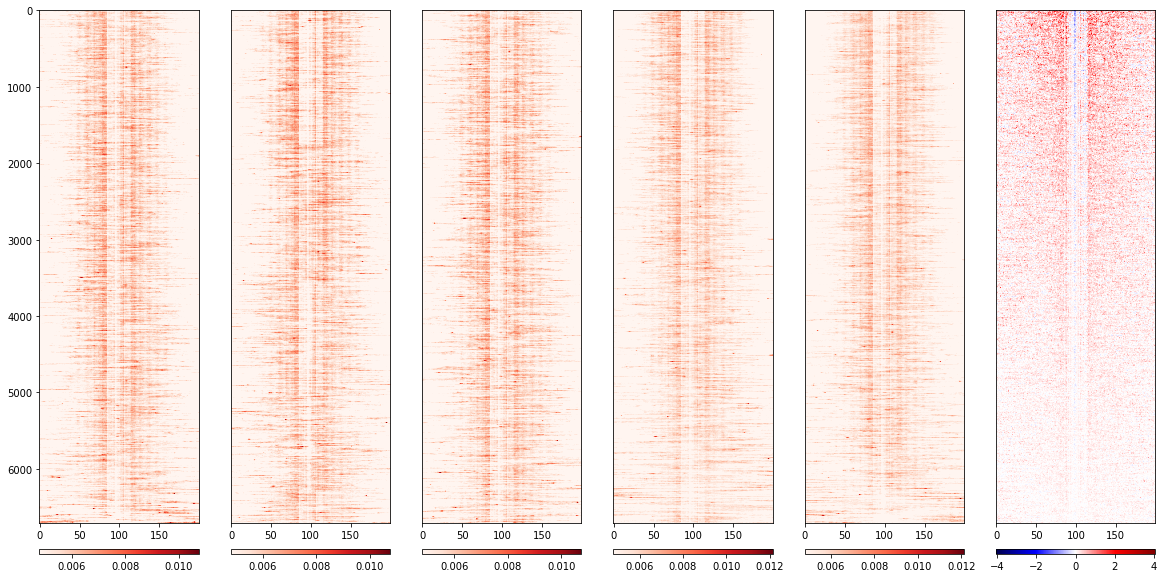

In [63]:

import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#no_signals=len(cwm_values)
fig,ax = plt.subplots(1,6,figsize = (20, 10), gridspec_kw={'width_ratios': [4, 4,  4, 4, 4, 4]})

vmin, vmax = np.percentile(cnts_values, [50, 98])
# lim = np.max([abs(vmin), abs(vmax)])
#vmin=0
#vmax=0.02
# vmax=lim
im1 = ax[0].imshow(cnts_values,cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
#ax[0].get_xaxis().set_visible(False)
#ax[0].get_yaxis().set_visible(False)

divider = make_axes_locatable(ax[0])
cay = divider.append_axes('bottom', size='1%', pad=0.35)
fig.colorbar(im1, cax=cay, orientation='horizontal')

idx = 1
vmin, vmax = np.percentile(pwm_values, [50, 98])
# lim = np.max([abs(vmin), abs(vmax)])
#vmin=0
#vmax=0.02
# vmax=+lim
#vmin=0
im2 = ax[idx].imshow(pwm_values,cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
vmin, vmax = np.percentile(pwm_values_sum, [1, 98])
ax[idx].get_xaxis().set_visible(True)

divider = make_axes_locatable(ax[idx])
cay = divider.append_axes('bottom', size='1%', pad=0.35)
fig.colorbar(im2, cax=cay, orientation='horizontal')

ax[idx].get_yaxis().set_visible(False)

idx = 2
vmin, vmax = np.percentile(TOBIAS_values, [50, 98])
# lim = np.max([abs(vmin), abs(vmax)])
#vmin=0
# vmax=+lim
#lim = np.max([abs(vmin), abs(vmax)])
#vmin=-lim
#vmax=0.02
# vmax=+lim
im2 = ax[idx].imshow(TOBIAS_values,cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
vmin, vmax = np.percentile(TOBIAS_values_sum, [50, 99])
ax[idx].get_xaxis().set_visible(True)

divider = make_axes_locatable(ax[idx])
cay = divider.append_axes('bottom', size='1%', pad=0.35)
fig.colorbar(im2, cax=cay, orientation='horizontal')

ax[idx].get_yaxis().set_visible(False)

idx=3
# corrected
vmin, vmax = np.percentile(cwm_values, [50, 99])
#lim = np.max([abs(vmin), abs(vmax)])
#vmin=-lim
#vmax=0.02
#vmax=+lim
#vmin=0
im2 = ax[idx].imshow(cwm_values,cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
ax[idx].get_xaxis().set_visible(True)
ax[idx].get_yaxis().set_visible(False)

divider = make_axes_locatable(ax[idx])
cay = divider.append_axes('bottom', size='1%', pad=0.35)
fig.colorbar(im2, cax=cay, orientation='horizontal')

idx=4
# corrected
import scipy.stats as stats
vmin, vmax = np.percentile(cwm_values_n, [50, 99])
# lim = np.max([abs(vmin), abs(vmax)])
#vmin=0
#vmax=0.02
# vmax=+lim
#lim = np.max([abs(vmin), abs(vmax)])
#vmin=-lim
#vmax=0.02
#vmax=+lim
#vmin=-0.1
im2 = ax[idx].imshow(cwm_values_n,cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
ax[idx].get_xaxis().set_visible(True)
ax[idx].get_yaxis().set_visible(False)

divider = make_axes_locatable(ax[idx])
cay = divider.append_axes('bottom', size='1%', pad=0.35)
fig.colorbar(im2, cax=cay, orientation='horizontal')

# idx=5
# # corrected
# vmin, vmax = np.percentile(cwm_values_chip, [1, 9])
# # lim = np.max([abs(vmin), abs(vmax)])
# vmin=0
# #vmax=0.02
# # vmax=+lim
# im2 = ax[idx].imshow(cwm_values_chip,cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
# ax[idx].get_xaxis().set_visible(True)
# ax[idx].get_yaxis().set_visible(False)

# divider = make_axes_locatable(ax[idx])
# cay = divider.append_axes('bottom', size='1%', pad=0.35)
# fig.colorbar(im2, cax=cay, orientation='horizontal')

idx=5
# corrected
vmin, vmax = np.percentile(TOBIAS_values_tobias, [1, 99])
lim = np.max([abs(vmin), abs(vmax)])
im2 = ax[idx].imshow(TOBIAS_values_tobias,cmap="seismic",aspect="auto",norm=mpl.colors.Normalize(vmin=-lim, vmax=+lim))
ax[idx].get_xaxis().set_visible(True)
ax[idx].get_yaxis().set_visible(False)

divider = make_axes_locatable(ax[idx])
cay = divider.append_axes('bottom', size='1%', pad=0.35)
fig.colorbar(im2, cax=cay, orientation='horizontal')


In [20]:
#hits_ordered_by_cwm

In [21]:
#list(set(hits[3]))